In [9]:
import cv2
import numpy as np

def generate_weak_mask_cxr(img_path):
    # 1. carregar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = cv2.resize(img, (512, 512))

    # 2. equalização + suavização
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    I = clahe.apply(img)
    I = cv2.GaussianBlur(I, (7,7), 0)

    # 3. inverter para que opacidades fiquem claras
    I_inv = cv2.normalize(255 - I, None, 0, 255, cv2.NORM_MINMAX)

    # 4. threshold adaptativo (invertido)
    bw = cv2.adaptiveThreshold(I_inv, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY,
                               51, 2)

    # 5. limpar regiões fora dos pulmões
    # remove topo claro / textos
    bw[:80, :] = 0

    # 6. morfologia para suavizar
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

    # 7. manter regiões internas
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
    mask_out = np.zeros_like(bw)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x,y,wc,hc = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        # descarta regiões no topo e muito pequenas
        if area > 500 and y > 50:
            mask_out[labels == i] = 255

    # 8. voltar ao tamanho original
    mask_out = cv2.resize(mask_out, (w, h))
    return (mask_out > 0).astype(np.uint8)


In [11]:
import os
from tqdm import tqdm

input_dir = "/kaggle/input/tuberculosis-chest-xrays-montgomery/images/images"
output_dir = "/kaggle/working/weak_masks"
os.makedirs(output_dir, exist_ok=True)

# Gera máscaras binárias de 0 ou 255.
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(".png"):
        img_path = os.path.join(input_dir, filename)
        mask = generate_weak_mask_cxr(img_path)
        cv2.imwrite(os.path.join(output_dir, filename), (mask*255))

100%|██████████| 138/138 [00:37<00:00,  3.72it/s]


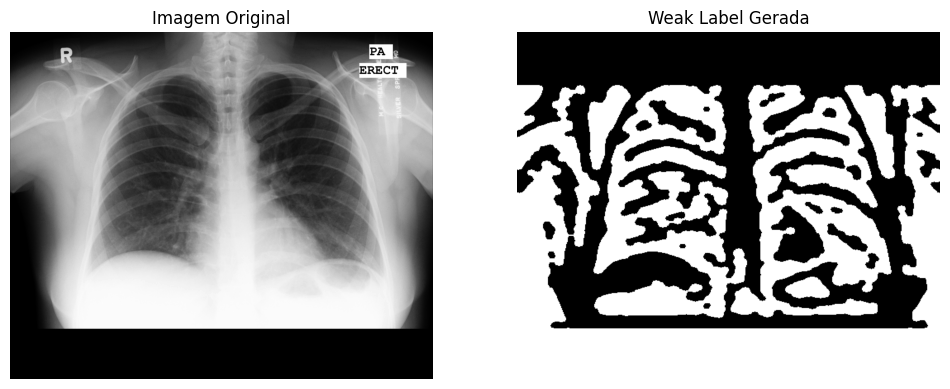

In [12]:
import matplotlib.pyplot as plt

sample = "MCUCXR_0001_0.png"

img = cv2.imread(os.path.join(input_dir, sample), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(output_dir, sample), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Imagem Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Weak Label Gerada")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()